In [64]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

In [2]:
df = pd.read_csv("ETF prices.csv")
df.head()

,fund_symbol,price_date,open,high,low,close,adj_close,volume
0,AAA,2020-09-09,25.10,25.12,25.07,25.07,24.85,17300
1,AAA,2020-09-10,25.06,25.07,25.05,25.07,24.85,23500
2,AAA,2020-09-11,25.04,25.05,25.02,25.03,24.81,33400
3,AAA,2020-09-14,25.01,25.06,25.01,25.02,24.80,13100
4,AAA,2020-09-15,25.02,25.03,25.01,25.01,24.79,12100


In [3]:
df.describe()

,open,high,low,close,adj_close,volume
count,3.866030e+06,3.866030e+06,3.866030e+06,3.866030e+06,3.866030e+06,3.866030e+06
mean,1.202537e+05,1.262811e+05,1.149734e+05,1.196726e+05,1.196579e+05,1.026745e+06
std,1.149917e+07,1.208270e+07,1.097204e+07,1.143655e+07,1.143655e+07,1.275733e+07
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.486000e+01,2.494000e+01,2.476000e+01,2.485000e+01,2.229000e+01,3.553000e+03
50%,3.388000e+01,3.406000e+01,3.368000e+01,3.387000e+01,3.108000e+01,2.133900e+04
75%,5.417000e+01,5.441000e+01,5.390000e+01,5.416000e+01,5.007000e+01,1.269000e+05
max,2.656750e+09,2.808750e+09,2.609750e+09,2.808750e+09,2.808750e+09,2.987062e+09


In [4]:
distinct_values = df['fund_symbol'].value_counts()
print(distinct_values)

fund_symbol
SPY     7263
EWC     6472
EWA     6472
EWD     6472
DIA     6007
        ... 
BKCH      98
HVAL      95
VSPY      94
LOPX      92
JIDA      89
Name: count, Length: 2310, dtype: int64


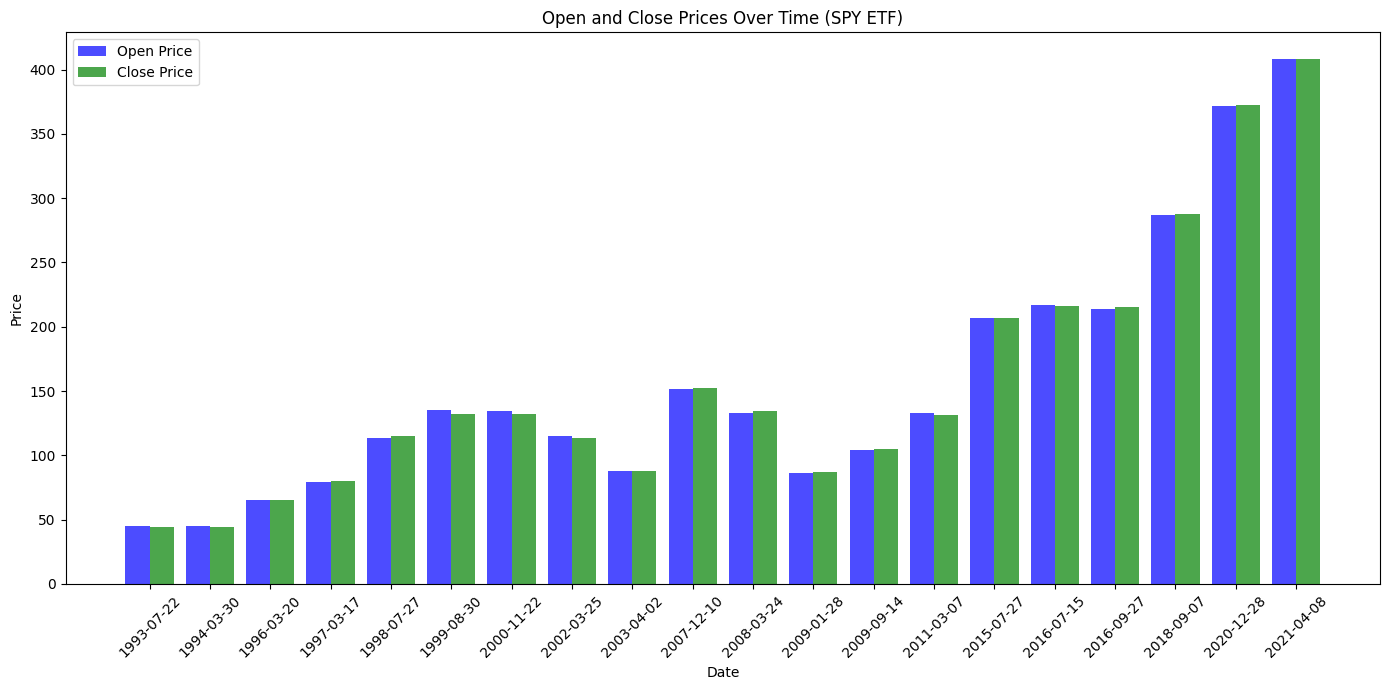

In [5]:
df['price_date'] = pd.to_datetime(df['price_date'])

spy_df = df[df['fund_symbol'] == 'SPY']

sample_spy_df = spy_df.sample(n=20, random_state=12)

sample_spy_df = sample_spy_df.sort_values(by='price_date')
bar_width = 0.4

x = range(len(sample_spy_df))

plt.figure(figsize=(14, 7))

plt.bar(x, sample_spy_df['open'], width=bar_width, label='Open Price', color='blue', alpha=0.7)

plt.bar([p + bar_width for p in x], sample_spy_df['close'], width=bar_width, label='Close Price', color='green', alpha=0.7)

plt.title('Open and Close Prices Over Time (SPY ETF)')
plt.xlabel('Date')
plt.ylabel('Price')

plt.xticks([p + bar_width / 2 for p in x], sample_spy_df['price_date'].dt.date, rotation=45)

plt.legend()

plt.tight_layout()

plt.show()


C:\Users\vishv\AppData\Local\Temp\ipykernel_8864\323306414.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='fund_symbol', y='volume', data=avg_volume_per_fund, palette='muted')


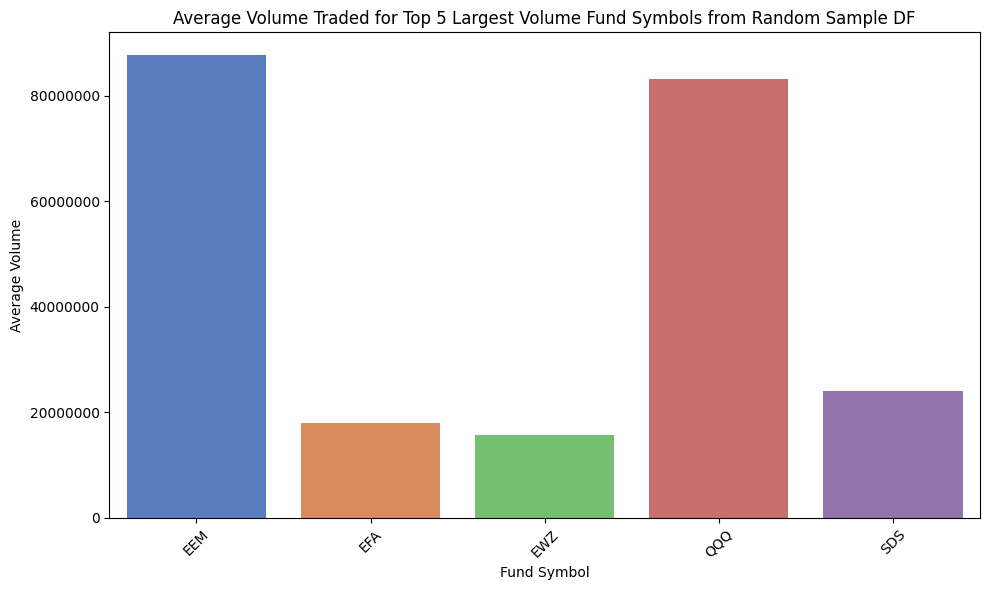

In [6]:
sample_df = df.sample(n=1000, random_state=12)
top_fund_symbols = sample_df.groupby('fund_symbol')['volume'].sum().nlargest(5).index

filtered_df = sample_df[sample_df['fund_symbol'].isin(top_fund_symbols)]

avg_volume_per_fund = filtered_df.groupby('fund_symbol')['volume'].mean().reset_index()

plt.figure(figsize=(10, 6))
sns.barplot(x='fund_symbol', y='volume', data=avg_volume_per_fund, palette='muted')

plt.title('Average Volume Traded for Top 5 Largest Volume Fund Symbols from Random Sample DF')
plt.xlabel('Fund Symbol')
plt.ylabel('Average Volume')
plt.xticks(rotation=45) 
plt.ticklabel_format(style='plain', axis='y')
plt.tight_layout()
plt.show()



In [7]:
df = df.drop_duplicates()
df = df.dropna()
etf_counts = df['fund_symbol'].value_counts()
valid_etfs = etf_counts[etf_counts >= 99].index
df = df[df['fund_symbol'].isin(valid_etfs)]
df.head(10)

,fund_symbol,price_date,open,high,low,close,adj_close,volume
0,AAA,2020-09-09,25.10,25.12,25.07,25.07,24.85,17300
1,AAA,2020-09-10,25.06,25.07,25.05,25.07,24.85,23500
2,AAA,2020-09-11,25.04,25.05,25.02,25.03,24.81,33400
3,AAA,2020-09-14,25.01,25.06,25.01,25.02,24.80,13100
4,AAA,2020-09-15,25.02,25.03,25.01,25.01,24.79,12100
5,AAA,2020-09-16,24.97,24.98,24.97,24.97,24.75,14100
6,AAA,2020-09-17,24.99,25.00,24.98,24.98,24.76,15200
7,AAA,2020-09-18,24.97,24.98,24.97,24.98,24.76,5300
8,AAA,2020-09-21,24.99,24.99,24.98,24.98,24.76,8600
9,AAA,2020-09-22,24.98,24.99,24.98,24.98,24.76,8100


In [10]:
null_values_open = df['open'].isnull().sum()
null_values_close = df['close'].isnull().sum()

zero_values_open = (df['open'] == 0).sum()
zero_values_close = (df['close'] == 0).sum()

print(f"Number of null or NaN values in 'open': {null_values_open}")
print(f"Number of null or NaN values in 'close': {null_values_close}")
print(f"Number of zero values in 'open': {zero_values_open}")
print(f"Number of zero values in 'close': {zero_values_close}")

Number of null or NaN values in 'open': 0
Number of null or NaN values in 'close': 0
Number of zero values in 'open': 8
Number of zero values in 'close': 8


In [9]:
zero_values_open = (df['open'] == 0).sum()
zero_values_close = (df['close'] == 0).sum()

In [11]:
zero_open_df = df[df['open'] == 0]
zero_close_df = df[df['close'] == 0]

print("Rows where 'open' is 0:")
print(zero_open_df)

print("\nRows where 'close' is 0:")
print(zero_close_df)

Rows where 'open' is 0:
        fund_symbol price_date  open  high  low  close  adj_close  volume
1142682        FLQL 2017-06-20   0.0   0.0  0.0    0.0        0.0       0
1143800        FLQM 2017-06-20   0.0   0.0  0.0    0.0        0.0       0
1144918        FLQS 2017-06-20   0.0   0.0  0.0    0.0        0.0       0
1388072        GIGB 2017-07-03   0.0   0.0  0.0    0.0        0.0       0
2105283        JPST 2017-06-23   0.0   0.0  0.0    0.0        0.0       0
3425630        TUSA 2014-12-23   0.0   0.0  0.0    0.0        0.0       0
3564346        USOI 2017-06-19   0.0   0.0  0.0    0.0        0.0       0
3689801        VSDA 2017-06-13   0.0   0.0  0.0    0.0        0.0       0

Rows where 'close' is 0:
        fund_symbol price_date  open  high  low  close  adj_close  volume
1142682        FLQL 2017-06-20   0.0   0.0  0.0    0.0        0.0       0
1143800        FLQM 2017-06-20   0.0   0.0  0.0    0.0        0.0       0
1144918        FLQS 2017-06-20   0.0   0.0  0.0    0.0        

In [12]:
df = df[(df['open'] != 0) & (df['close'] != 0)]

In [16]:
df['lag_open'] = df.groupby('fund_symbol')['open'].shift(1)
df['lag_close'] = df.groupby('fund_symbol')['close'].shift(1)
df = df.dropna()
df.head()

,fund_symbol,price_date,open,high,low,close,adj_close,volume,lag_open,lag_close
1,AAA,2020-09-10,25.06,25.07,25.05,25.07,24.85,23500,25.10,25.07
2,AAA,2020-09-11,25.04,25.05,25.02,25.03,24.81,33400,25.06,25.07
3,AAA,2020-09-14,25.01,25.06,25.01,25.02,24.80,13100,25.04,25.03
4,AAA,2020-09-15,25.02,25.03,25.01,25.01,24.79,12100,25.01,25.02
5,AAA,2020-09-16,24.97,24.98,24.97,24.97,24.75,14100,25.02,25.01


In [40]:
predictions = []
etfs = df['fund_symbol'].unique()


In [41]:
for etf in etfs:
    etf_data = df[df['fund_symbol'] == etf].copy()

    X = etf_data[['lag_open', 'lag_close']]
    y_open = etf_data['open']
    y_close = etf_data['close']

    X_train, X_test, y_train_open, y_test_open, y_train_close, y_test_close = train_test_split(
        X, y_open, y_close, test_size=0.2, shuffle=False
    )

    model_open = LinearRegression()
    model_open.fit(X_train, y_train_open)

    model_close = LinearRegression()
    model_close.fit(X_train, y_train_close)

    y_pred_open = model_open.predict(X_test)
    y_pred_close = model_close.predict(X_test)

    mae_open = mean_absolute_error(y_test_open, y_pred_open)
    r2_open = r2_score(y_test_open, y_pred_open)
    
    mae_close = mean_absolute_error(y_test_close, y_pred_close)
    r2_close = r2_score(y_test_close, y_pred_close)

    last_row = etf_data.tail(1)[['lag_open', 'lag_close']]
    pred_open = model_open.predict(last_row)
    pred_close = model_close.predict(last_row)
  
    predictions.append({
        'fund_symbol': etf,
        'pred_open': pred_open[0],
        'pred_close': pred_close[0],
        'mae_open': mae_open,
        'r2_open': r2_open,
        'mae_close': mae_close,
        'r2_close': r2_close
    })

predictions_df = pd.DataFrame(predictions)
predictions_df.head()

,fund_symbol,pred_open,pred_close,mae_open,r2_open,mae_close,r2_close
0,AAA,25.032756,25.029634,0.008002,0.684793,0.006614,0.567619
1,AAAU,17.746191,17.730888,0.084326,0.925720,0.106775,0.884967
2,AADR,62.381481,62.287390,0.465521,0.991789,0.628356,0.986207
3,AAXJ,83.458466,83.489346,0.658365,0.993148,0.769643,0.991095
4,ABEQ,27.516360,27.519872,0.127942,0.814719,0.123040,0.832093


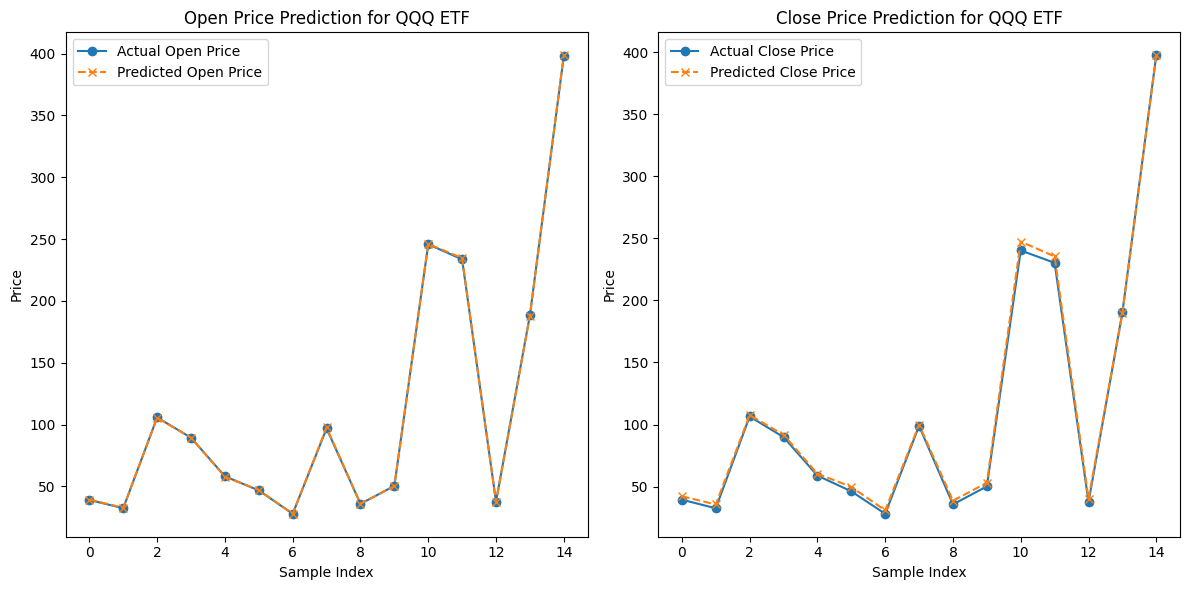

In [58]:
etf_symbol = 'QQQ' 
etf_data = df[df['fund_symbol'] == etf_symbol]

random_samples = etf_data.sample(n=15, random_state=42)

X_test = random_samples[['lag_open', 'lag_close']]
y_test_open = random_samples['open']
y_test_close = random_samples['close']

y_pred_open = model_open.predict(X_test)
y_pred_close = model_close.predict(X_test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(y_test_open.values, label='Actual Open Price', marker='o')
plt.plot(y_pred_open, label='Predicted Open Price', linestyle='--', marker='x')
plt.title(f'Open Price Prediction for {etf_symbol} ETF')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_close.values, label='Actual Close Price', marker='o')
plt.plot(y_pred_close, label='Predicted Close Price', linestyle='--', marker='x')
plt.title(f'Close Price Prediction for {etf_symbol} ETF')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()

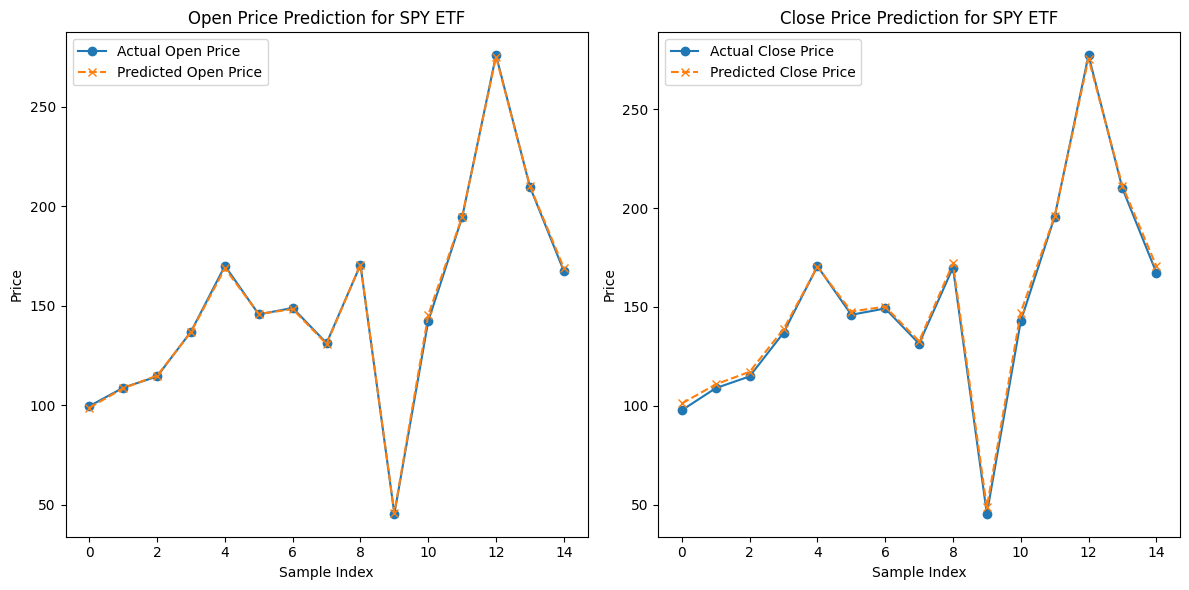

In [59]:
etf_symbol = 'SPY' 
etf_data = df[df['fund_symbol'] == etf_symbol]

random_samples = etf_data.sample(n=15, random_state=42)

X_test = random_samples[['lag_open', 'lag_close']]
y_test_open = random_samples['open']
y_test_close = random_samples['close']

y_pred_open = model_open.predict(X_test)
y_pred_close = model_close.predict(X_test)

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(y_test_open.values, label='Actual Open Price', marker='o')
plt.plot(y_pred_open, label='Predicted Open Price', linestyle='--', marker='x')
plt.title(f'Open Price Prediction for {etf_symbol} ETF')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(y_test_close.values, label='Actual Close Price', marker='o')
plt.plot(y_pred_close, label='Predicted Close Price', linestyle='--', marker='x')
plt.title(f'Close Price Prediction for {etf_symbol} ETF')
plt.xlabel('Sample Index')
plt.ylabel('Price')
plt.legend()

plt.tight_layout()
plt.show()

In [60]:
predictions_df['price_change'] = predictions_df['pred_close'] - predictions_df['pred_open']
predictions_df['return_percentage'] = (predictions_df['price_change'] / predictions_df['pred_open']) * 100
predictions_df.head()


,fund_symbol,pred_open,pred_close,mae_open,r2_open,mae_close,r2_close,price_change,return_percentage
0,AAA,25.032756,25.029634,0.008002,0.684793,0.006614,0.567619,-0.003122,-0.012472
1,AAAU,17.746191,17.730888,0.084326,0.925720,0.106775,0.884967,-0.015303,-0.086231
2,AADR,62.381481,62.287390,0.465521,0.991789,0.628356,0.986207,-0.094091,-0.150831
3,AAXJ,83.458466,83.489346,0.658365,0.993148,0.769643,0.991095,0.030880,0.037000
4,ABEQ,27.516360,27.519872,0.127942,0.814719,0.123040,0.832093,0.003511,0.012761


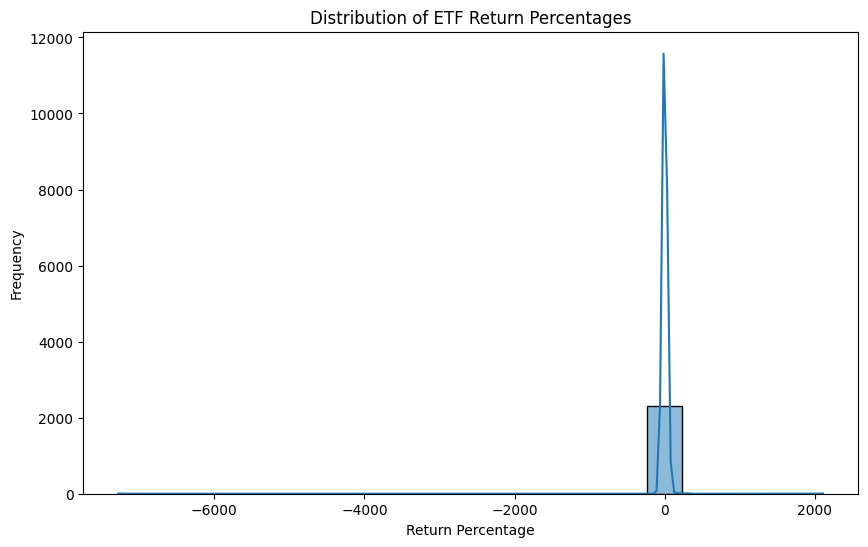

In [61]:
plt.figure(figsize=(10, 6))
sns.histplot(predictions_df['return_percentage'], bins=20, kde=True)
plt.title('Distribution of ETF Return Percentages')
plt.xlabel('Return Percentage')
plt.ylabel('Frequency')
plt.show()

In [73]:
predictions_df['category'] = np.where(predictions_df['return_percentage'] < 0, 'Loss', None)
non_negative = predictions_df[predictions_df['return_percentage'] >= 0]
non_negative['category'] = pd.qcut(non_negative['return_percentage'], q=3, labels=['Low', 'Medium', 'High'])
predictions_df.update(non_negative)

predictions_df.head()


C:\Users\vishv\AppData\Local\Temp\ipykernel_8864\176681319.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_negative['category'] = pd.qcut(non_negative['return_percentage'], q=3, labels=['Low', 'Medium', 'High'])


,fund_symbol,pred_open,pred_close,mae_open,r2_open,mae_close,r2_close,price_change,return_percentage,category
0,AAA,25.032756,25.029634,0.008002,0.684793,0.006614,0.567619,-0.003122,-0.012472,Loss
1,AAAU,17.746191,17.730888,0.084326,0.925720,0.106775,0.884967,-0.015303,-0.086231,Loss
2,AADR,62.381481,62.287390,0.465521,0.991789,0.628356,0.986207,-0.094091,-0.150831,Loss
3,AAXJ,83.458466,83.489346,0.658365,0.993148,0.769643,0.991095,0.030880,0.037000,Medium
4,ABEQ,27.516360,27.519872,0.127942,0.814719,0.123040,0.832093,0.003511,0.012761,Low


In [74]:
predictions_df.count

<bound method DataFrame.count of      fund_symbol   pred_open  pred_close  mae_open   r2_open  mae_close  \
0            AAA   25.032756   25.029634  0.008002  0.684793   0.006614   
1           AAAU   17.746191   17.730888  0.084326  0.925720   0.106775   
2           AADR   62.381481   62.287390  0.465521  0.991789   0.628356   
3           AAXJ   83.458466   83.489346  0.658365  0.993148   0.769643   
4           ABEQ   27.516360   27.519872  0.127942  0.814719   0.123040   
...          ...         ...         ...       ...       ...        ...   
2300        ZHDG   20.866735   20.742562  0.101643  0.258580   0.094133   
2301         ZIG   30.329164   30.249591  0.127311  0.977010   0.165365   
2302       ZIVZF   31.634505   31.614035  0.634588  0.995561   0.667712   
2303        ZROZ  154.722710  154.501327  1.242295  0.985422   1.696369   
2304         ZSL   28.413942   31.441454  1.738782  0.990246   3.763295   

      r2_close  price_change  return_percentage category  
0     0

In [76]:
X = predictions_df[['price_change', 'return_percentage']]
y = predictions_df['category']

clf = RandomForestClassifier(random_state=42)
clf.fit(X, y)

predictions_df['predicted_category'] = clf.predict(X)

print(classification_report(y, predictions_df['predicted_category']))

classified_df = predictions_df.copy()

print(classified_df.head())

              precision    recall  f1-score   support

        High       1.00      1.00      1.00       238
        Loss       1.00      1.00      1.00      1591
         Low       1.00      1.00      1.00       238
      Medium       1.00      1.00      1.00       238

    accuracy                           1.00      2305
   macro avg       1.00      1.00      1.00      2305
weighted avg       1.00      1.00      1.00      2305

  fund_symbol  pred_open  pred_close  mae_open   r2_open  mae_close  r2_close  \
0         AAA  25.032756   25.029634  0.008002  0.684793   0.006614  0.567619   
1        AAAU  17.746191   17.730888  0.084326  0.925720   0.106775  0.884967   
2        AADR  62.381481   62.287390  0.465521  0.991789   0.628356  0.986207   
3        AAXJ  83.458466   83.489346  0.658365  0.993148   0.769643  0.991095   
4        ABEQ  27.516360   27.519872  0.127942  0.814719   0.123040  0.832093   

   price_change  return_percentage category predicted_category  
0     -0.0031

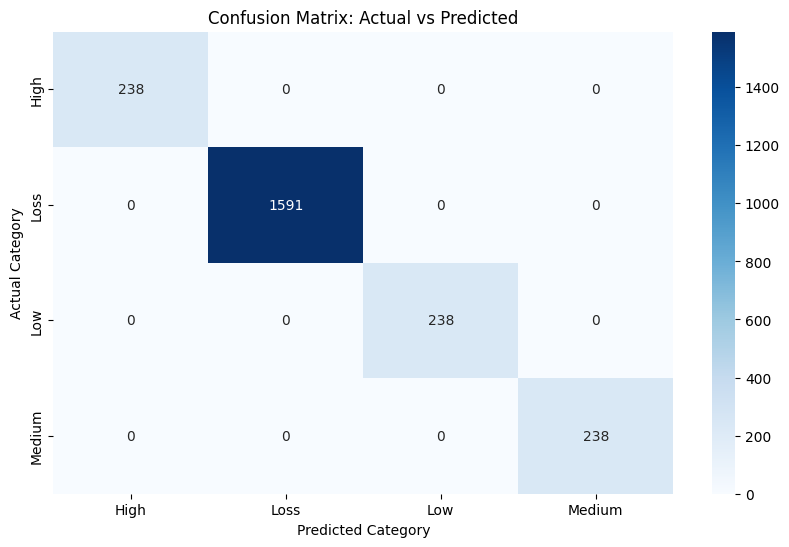

In [78]:
conf_matrix = confusion_matrix(y, predictions_df['predicted_category'])
plt.figure(figsize=(10, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=clf.classes_, yticklabels=clf.classes_)
plt.title('Confusion Matrix: Actual vs Predicted')
plt.xlabel('Predicted Category')
plt.ylabel('Actual Category')
plt.show()